In [1]:
import os
import ee
import json
import requests
import folium
import os, urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapely.geometry
import matplotlib.gridspec as gridspec
%matplotlib inline

ee.Initialize()

# Raster data

Create a target url for tiles

In [2]:
def tile_url(image, viz_params=None):
    """Create a target url for tiles for an image.
    e.g.
    im = ee.Image("LE7_TOA_1YEAR/" + year).select("B3","B2","B1")
    viz = {'opacity': 1, 'gain':3.5, 'bias':4, 'gamma':1.5}
    url = tile_url(image=im),viz_params=viz)
    """
    if viz_params:
        d = image.getMapId(viz_params)
    else:
        d = image.getMapId()
    base_url = 'https://earthengine.googleapis.com'
    url = (base_url + '/map/' + d['mapid'] + '/{z}/{x}/{y}?token=' + d['token'])
    return url

Functions to export tiles as png

In [3]:
def get_path(image):
    return image.getThumbURL({'region' : geometry.getInfo(), 'format': 'png', 'dimensions': 1024})

def download(image, path_out):
    path = get_path(image)
    
    if os.path.exists(path_out):
            os.remove(path_out)
    
    urllib.request.urlretrieve(path, path_out)

Arrays with dates

In [4]:
period = np.array(pd.period_range('2007-10', '2009-06', freq='M').to_series().astype(str))
period1 = np.array(pd.period_range(start='2007-10-01', end='2008-02-29', freq='D').to_series().astype(str))
period2 = np.array(pd.period_range(start='2008-04-01', end='2008-08-31', freq='D').to_series().astype(str))
period3 = np.array(pd.period_range(start='2008-10-01', end='2009-02-28', freq='D').to_series().astype(str))

Define geometries

In [5]:
# Botswana boundary
countries = ee.FeatureCollection('ft:1tdSwUL7MVpOauSgRzqVTOwdfy17KDbw-1d9omPw')
country_names = ['Botswana'] 
myCountry = countries.filter(ee.Filter.inList('Country', country_names))
aoi = ee.Geometry(myCountry)

In [6]:
# Rectangle around Botswana
geometry = ee.Geometry.Rectangle([19.5, -27.5, 29.8, -17.5])

### CHIRPS Pentad: Climate Hazards Group InfraRed Precipitation with Station Data (version 2.0 final)

**Preview tiles using folium**

In [8]:
col = ee.ImageCollection(f'UCSB-CHG/CHIRPS/PENTAD').filterDate(period[0],period[0+1])

# composite = image.clip(aoi)
composite = col.sum().clip(aoi)

ee_tiles = tile_url(composite, {'min':0,'max':1000,'palette':"white,blue,darkblue,red,purple"})
ee_tiles

'https://earthengine.googleapis.com/map/f8fcdfc9f0efb278de36144094c17666/{z}/{x}/{y}?token=b58ef6d162f83791665d4ba730795e57'

In [9]:
sentinel_map = folium.Map(location=[-21.953235600364483,24.224853515625], zoom_start=6, tiles='Mapbox Bright' )
sentinel_map.add_tile_layer(tiles=ee_tiles, max_zoom=19, min_zoom=1, attr="Live EE tiles")
sentinel_map

**Export images as GeoTiff**

In [ ]:
for t in range(len(period)-1):
    
    col = ee.ImageCollection(f'UCSB-CHG/CHIRPS/PENTAD').filterDate(period[t],period[t+1])

    composite = col.sum().clip(aoi)

    ee.batch.Export.image.toDrive(
        image = composite,
        folder = 'EarthPulse',
        fileNamePrefix = 'CHIRPS_'+period[t],
        scale = 1000,
        crs = 'EPSG:4326',
        region = geometry,
        fileFormat= 'GeoTIFF').start()

**Export images as png**

In [ ]:
vis = {'min':0,'max':400,'palette':"white,blue,darkblue,red,purple"}

#for t in range(len(period)-1):
dt = 30
step = 5
for t in range(len(period2)-dt):
    
    #col = ee.ImageCollection(f'UCSB-CHG/CHIRPS/PENTAD').filterDate(period[t],period[t+1])
    col = ee.ImageCollection(f'UCSB-CHG/CHIRPS/PENTAD').filterDate(period2[t+(step*t)],period2[t+dt+(step*t)])

    image = col.sum().clip(aoi)

    im = image.visualize(**vis)

    path = './images/CHIRPS/CHIRPS_'+period[t]+'.png'
    download(im, path)

In [ ]:
plt.figure(figsize=[8,8])
plt.imshow(plt.imread(path))

### TRMM: Tropical Rainfall Measuring Mission

**Preview tiles using folium**

In [10]:
col = ee.ImageCollection('TRMM/3B42').filterDate(period[0],period[0+1])

# composite = image.clip(aoi)
composite = col.sum().clip(aoi)

ee_tiles = tile_url(composite, {'bands': 'precipitation', 'min':0,'max':100,'palette':"white,blue,darkblue,red,purple"})
ee_tiles

'https://earthengine.googleapis.com/map/16c3af6b52c10b037882b94204308d02/{z}/{x}/{y}?token=70beebdfc08cc589d667444a352165df'

In [11]:
sentinel_map = folium.Map(location=[-21.953235600364483,24.224853515625], zoom_start=6, tiles='Mapbox Bright' )
sentinel_map.add_tile_layer(tiles=ee_tiles, max_zoom=19, min_zoom=1, attr="Live EE tiles")
sentinel_map

### MODIS Terra Daily NDVI

**Preview tiles using folium**

In [7]:
col = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(period[0],period[0+1])

# composite = image.clip(aoi)
composite = col.mean().clip(aoi)

ee_tiles = tile_url(composite, {'min':0,'max':0.8,'palette':"darkorange,yellow,green,darkgreen"})
ee_tiles

'https://earthengine.googleapis.com/map/70ab5d99f2a37772cce9c2e561410aab/{z}/{x}/{y}?token=22cc0e68eebf19e9e125128ab6df84df'

In [8]:
sentinel_map = folium.Map(location=[-21.953235600364483,24.224853515625], zoom_start=6, tiles='Mapbox Bright' )
sentinel_map.add_tile_layer(tiles=ee_tiles, max_zoom=19, min_zoom=1, attr="Live EE tiles")
sentinel_map

**Export images as GeoTiff**

In [ ]:
for t in range(len(period)-1):
    
    col = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(period[t],period[t+1])

    composite = col.mean().clip(aoi)

    ee.batch.Export.image.toDrive(
        image = composite,
        folder = 'EarthPulse',
        fileNamePrefix = 'NDVI_'+period[t],
        scale = 500,
        crs = 'EPSG:4326',
        region = geometry,
        fileFormat= 'GeoTIFF').start()

**Export images as png**

In [ ]:
vis = {'min':0,'max':0.8,'palette':"darkorange,yellow,green,darkgreen"}

for t in range(len(period)-1):
    
    col = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(period[t],period[t+1])

    image = col.mean().clip(aoi)

    im = image.visualize(**vis)

    path = './images/NDVI/period/NDVI_'+period[t]+'.png'
    download(im, path)

In [ ]:
vis = {'min':0,'max':0.8,'palette':"darkorange,yellow,green,darkgreen"}

dt = 30
for t in range(len(period2)-dt):
    
    col = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(period2[t],period2[t+dt])

    image = col.mean().clip(aoi)

    im = image.visualize(**vis)

    path = './images/NDVI/NDVI_'+period2[t]+'.png'
    download(im, path)

In [ ]:
plt.figure(figsize=[8,8])
plt.imshow(plt.imread(path))

### MODIS Surface Reflectance QA

**Preview tiles using folium**

In [9]:
# A function to mask out pixels that did not have observations.
def maskEmptyPixels(image):
    # Find pixels that had observations.
    withObs = image.select('num_observations_1km').gt(1)
    return image.updateMask(withObs)

In [10]:
# A function to mask out cloudy pixels.
def maskClouds(image): 
    # Select the QA band.
    QA = image.select('state_1km')
    # Make a mask to get bit 10, the internal_cloud_algorithm_flag bit.
    bitMask = ee.Number(2).pow(10).int()
    # Return an image masking out cloudy areas.
    return image.updateMask(QA.bitwiseAnd(bitMask).eq(0))

In [11]:
# Take an image collection and mask out areas that were not observed.
col = ee.ImageCollection('MODIS/006/MOD09GA').filterDate(period[0],period[0+1]).map(maskEmptyPixels)

# Map the cloud masking function over the collection.
collectionCloudMasked = col.map(maskClouds)

composite = collectionCloudMasked.median().clip(aoi)

In [12]:
ee_tiles = tile_url(composite, {'bands': 'sur_refl_b01, sur_refl_b04, sur_refl_b03','gain': 0.07,'gamma': 1.4})
ee_tiles

'https://earthengine.googleapis.com/map/292a79eac2b2494b9afe68305e2246b3/{z}/{x}/{y}?token=7ed2209f95ae0777872eecdaf40eabd7'

In [13]:
sentinel_map = folium.Map(location=[-21.953235600364483,24.224853515625], zoom_start=6, tiles='Mapbox Bright' )
sentinel_map.add_tile_layer(tiles=ee_tiles, max_zoom=19, min_zoom=1, attr="Live EE tiles")
sentinel_map

**Export images as png**

One month average with 5 days time step

In [ ]:
vis = {'bands': 'sur_refl_b01,sur_refl_b04,sur_refl_b03','gain': 0.07,'gamma': 1.4}

#for t in range(len(period)-1):
dt = 30
step = 5
for t in range(1):
#for t in range(len(period2)-dt):
    
    # Take an image collection and mask out areas that were not observed.
    #col = ee.ImageCollection('MODIS/006/MOD09GA').filterDate(period[t],period[t+1])
    col = ee.ImageCollection('MODIS/006/MOD09GA').filterDate(period2[t+(step*t)],period2[t+dt+(step*t)])

    # Map the cloud masking function over the collection.
    collectionCloudMasked = col.map(maskClouds)

    image = collectionCloudMasked.median().clip(aoi)

    im = image.visualize(**vis)

    path = './images/MODIS/MODIS_'+period2[t+(step*t)]+'.png'
    download(im, path)

In [ ]:
plt.figure(figsize=[8,8])
plt.imshow(plt.imread(path))

# Evolution of indexes 

From GEE image to Numpy array

In [21]:
def gee_to_numpy(img,area, maxPixels=1e8, scale=1000):
    # get the lat lon and add the image
    latlon = ee.Image.pixelLonLat().addBands(img)
    
    # apply reducer to list
    latlon = latlon.reduceRegion(
      reducer=ee.Reducer.toList(),
      geometry=area,
      maxPixels=maxPixels,
      scale=scale);
  
    # get data into three different arrays
    name = img.getInfo().get('bands')[0].get('id')
    data = np.array((ee.Array(latlon.get(name)).getInfo()))
    lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
    lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))
        
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)
 
    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)
 
    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]
 
    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32) #-9999

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
                
    return arr

**MODIS Terra Daily NDVI**

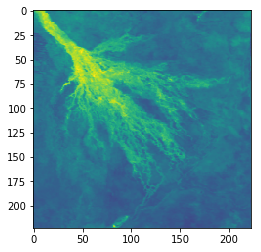

In [22]:
# Define the area
area = ee.Geometry.Rectangle([22, -20.5, 24, -18.5])

# Define the image (we us the .unmask() function to fills the null values in the image with -1)
col = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(period[0],period[0+1])
img = col.sum().clip(aoi).unmask(-1)

# Get array
arr = gee_to_numpy(img,area)

# Replace pixel with -1 values by NaN
arr[np.where(arr == -1)] = np.nan

# Plot the image
plt.imshow(arr)

In [23]:
area = ee.Geometry.Rectangle([22, -20.5, 24, -18.5])

index = []
for t in range(len(period)-1):
    # Get image
    col = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(period[t],period[t+1])
    img = col.mean().clip(aoi).unmask(-1)
    # Get array
    arr = gee_to_numpy(img,area)
    # Replace pixel with -1 values by NaN
    arr[np.where(arr == -1)] = np.nan
    
    index.append(np.nanmean(arr))

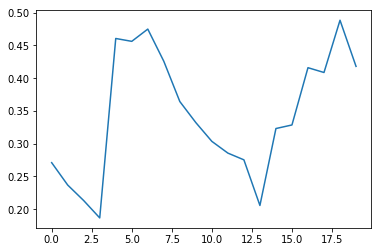

In [24]:
plt.plot(index)

**CHIRPS Pentad**

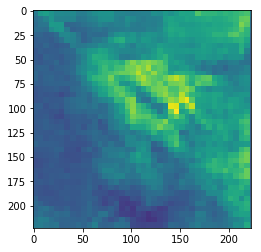

In [25]:
# Define the area
area = ee.Geometry.Rectangle([22, -20.5, 24, -18.5])

# Define the image (we us the .unmask() function to fills the null values in the image with -1)
col = ee.ImageCollection(f'UCSB-CHG/CHIRPS/PENTAD').filterDate(period[0],period[0+1])
img = col.sum().clip(aoi).unmask(-1)

# Get array
arr = gee_to_numpy(img,area)

# Replace pixel with -1 values by NaN
arr[np.where(arr == -1)] = np.nan

# Plot the image
plt.imshow(arr)

In [26]:
area = ee.Geometry.Rectangle([22, -20.5, 24, -18.5])

index = []
for t in range(len(period)-1):
    # Get image
    col = ee.ImageCollection(f'UCSB-CHG/CHIRPS/PENTAD').filterDate(period[t],period[t+1])
    img = col.mean().clip(aoi).unmask(-1)
    # Get array
    arr = gee_to_numpy(img,area)
    # Replace pixel with -1 values by NaN
    arr[np.where(arr == -1)] = np.nan
    
    index.append(np.nanmean(arr))

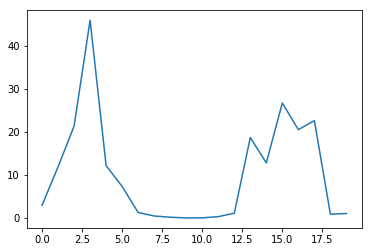

In [27]:
plt.plot(index)

# Zebra data

**Migrations**

In [28]:
from pprint import pprint

In [29]:
with open('zebra_migrations_lite.json') as f:
    migrations = json.load(f)

In [30]:
pprint(migrations.get('meta'))

{'data_fields': ['individual_local_identifier',
                 'location_lat',
                 'location_long',
                 'timestamp',
                 'visible',
                 'event_id'],
 'max_timestamp': '2009-06-01T15:00:08Z',
 'min_timestamp': '2007-10-25T00:02:11Z',
 'study_timezone': 'Central African Time',
 'zebra_id_keys': ['Z6407',
                   'Z3743',
                   'Z6402',
                   'Z3866',
                   'Z6405',
                   'Z3864',
                   'Z6399']}


In [31]:
pprint(migrations.get('migrations')[0].get('Z6407')[0])

{'event_id': 209251233,
 'individual_local_identifier': 'Z6407',
 'location_lat': -20.1921113,
 'location_long': 24.4252033,
 'timestamp': '2009-05-27T12:00:38Z',
 'visible': True}


Create a GeoDataFrame for first zebra

In [32]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [33]:
gdf = gpd.GeoDataFrame(columns=['event_id', 'zebra_id','lat','lng','geometry','timestamp']) 

In [34]:
zebra_id_keys = migrations.get('meta').get('zebra_id_keys')

In [35]:
for i, zebra_id in enumerate(zebra_id_keys): 
    for j in range(len(migrations.get('migrations')[i].get(zebra_id))):
        lat = migrations.get('migrations')[i].get(zebra_id)[j].get('location_lat')
        lng = migrations.get('migrations')[i].get(zebra_id)[j].get('location_long')
        point = Point(lng, lat)
        data = {'event_id': [migrations.get('migrations')[i].get(zebra_id)[j].get('event_id')],
                       'zebra_id': [migrations.get('migrations')[i].get(zebra_id)[j].get('individual_local_identifier')],
                       'lat': [lat],
                       'lng': [lng],
                       'geometry': [point],
                       'timestamp': [migrations.get('migrations')[i].get(zebra_id)[j].get('timestamp')]}
        gdf = pd.concat([gdf,gpd.GeoDataFrame.from_dict(data)])
gdf.reset_index(drop=True, inplace=True)

In [36]:
for i, zebra_id in enumerate(zebra_id_keys):
    zbi = gdf[gdf['zebra_id'] == zebra_id]
    print(zebra_id,len(zbi))
    print('Time range: ', zbi['timestamp'].min(), zbi['timestamp'].max())

Z6407 9680
Time range:  2008-08-27T08:01:17Z 2009-05-27T12:00:38Z
Z3743 10912
Time range:  2007-10-28T00:00:24Z 2008-08-28T09:00:41Z
Z6402 4837
Time range:  2008-10-24T07:00:42Z 2009-04-21T07:00:37Z
Z3866 13045
Time range:  2007-10-25T08:01:53Z 2008-10-22T23:00:45Z
Z6405 6194
Time range:  2008-08-27T05:00:44Z 2009-03-31T19:00:19Z
Z3864 2720
Time range:  2007-10-25T00:02:11Z 2008-01-05T04:30:06Z
Z6399 6389
Time range:  2008-10-24T09:01:48Z 2009-06-01T15:00:08Z


In [37]:
gdf_time = gdf[(gdf['zebra_id'] == 'Z3866') | (gdf['zebra_id'] == 'Z6399')]

In [38]:
gdf_time.head()

,event_id,zebra_id,lat,lng,geometry,timestamp
25429,209315664,Z3866,-19.431040,23.596221,POINT (23.5962208 -19.4310398),2008-10-22T23:00:45Z
25430,209315663,Z3866,-19.430229,23.596099,POINT (23.5960988 -19.4302291),2008-10-22T22:00:11Z
25431,209315662,Z3866,-19.429891,23.595988,POINT (23.5959876 -19.4298906),2008-10-22T21:00:13Z
25432,209315661,Z3866,-19.429933,23.596006,POINT (23.5960061 -19.4299326),2008-10-22T20:00:40Z
25433,209315660,Z3866,-19.430250,23.595892,POINT (23.5958921 -19.4302504),2008-10-22T19:00:27Z


In [39]:
print('Time range: ', gdf_time['timestamp'].min(), gdf_time['timestamp'].max())

Time range:  2007-10-25T08:01:53Z 2009-06-01T15:00:08Z


Botswana border 

In [40]:
countries = gpd.read_file('./all_countries/all_countries.shp')
border_mask = countries['iso_a3'] == 'BWA'
bwa_border = countries[border_mask]

Buffer of zebra position during a period between '2008-10' - '2008-11' and the whole time sequence 

In [41]:
gdf_period = gdf_time[(gdf_time['timestamp'] > '2008-10') & (gdf_time['timestamp'] < '2008-11')]

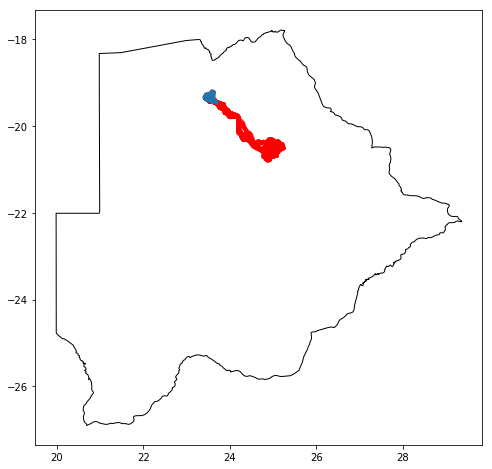

In [42]:
fig, ax = plt.subplots(figsize=[8,8])

bwa_border.geometry.plot(ax=ax, color='white', edgecolor='black')
gdf_time.geometry.buffer(0.05).plot(ax=ax,color='r',alpha=0.5)
gdf_period.geometry.buffer(0.05).plot(ax=ax,alpha=0.5)

**Polygons**

In [43]:
with open('zebra_polygons_z3866.json') as f:
    polygons_z3866 = json.load(f)
    
with open('zebra_polygons_z6399.json') as f:
    polygons_z6399 = json.load(f)

In [44]:
polygon = ee.Geometry.Polygon(polygons_z3866.get('data')[0].get('geometry').get('coordinates'))

In [45]:
pprint(polygons_z3866.get('data')[0].get('dateRange'))

['2007-11-01T00:00:00Z', '2007-12-01T00:00:00Z']


In [46]:
pprint(polygons_z3866.get('data')[0].get('area'))

0.2872934305465933


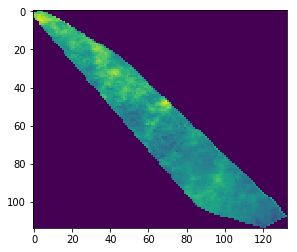

In [47]:
# Get the polygon
polygon = ee.Geometry.Polygon(polygons_z3866.get('data')[0].get('geometry').get('coordinates'))

# Define the image
dataRange = polygons_z3866.get('data')[0].get('dateRange')
col = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(dataRange[0],dataRange[1])
img = col.mean().clip(aoi).unmask(-1)

# Get array
arr = gee_to_numpy(img,polygon)

# Replace pixel with -1 values by NaN
arr[np.where(arr == -1)] = np.nan

# Plot the image
plt.imshow(arr)

In [48]:
index_NDVI = []
index_CHIRPS = []
area = []
for polygons in [polygons_z3866, polygons_z6399]:
    for t in range(len(polygons.get('data'))):
        # Get polygon
        area.append(polygons.get('data')[t].get('area'))
        # Get area
        polygon = ee.Geometry.Polygon(polygons.get('data')[t].get('geometry').get('coordinates'))
        # Get image
        dataRange = polygons.get('data')[t].get('dateRange')
    
        col_NDVI = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(dataRange[0],dataRange[1])
        col_CHIRPS = ee.ImageCollection(f'UCSB-CHG/CHIRPS/PENTAD').filterDate(dataRange[0],dataRange[1])
    
        img_NDVI = col_NDVI.mean().clip(aoi).unmask(-1)
        img_CHIRPS = col_CHIRPS.mean().clip(aoi).unmask(-1)
        # Get array
        arr_NDVI = gee_to_numpy(img_NDVI,polygon)
        arr_CHIRPS = gee_to_numpy(img_CHIRPS,polygon)
        # Replace pixel with -1 values by NaN
        arr_NDVI[np.where(arr_NDVI == -1)] = np.nan
        arr_CHIRPS[np.where(arr_CHIRPS == -1)] = np.nan
    
        index_NDVI.append(np.nanmean(arr_NDVI))
        index_CHIRPS.append(np.nanmean(arr_CHIRPS))

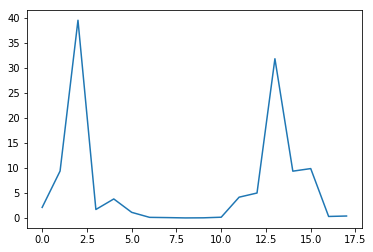

In [49]:
plt.plot(index_CHIRPS)

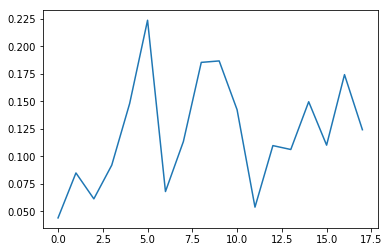

In [50]:
plt.plot(index_NDVI)

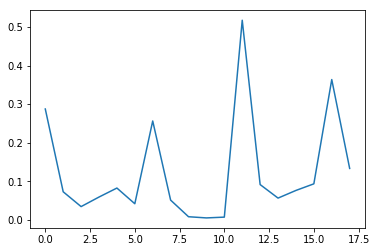

In [51]:
plt.plot(area)

**Delta**

In [52]:
delta = ee.Geometry.Polygon([[21.917724609375,-18.07797898663566],
[21.5606689453125,-18.359739156553683],
[22.576904296875,-20.730428476781324],
[23.6041259765625,-20.102364832944886],
[24.290771484375,-19.222989930581818],
[23.642578125,-18.588982352118443],
[21.917724609375,-18.07797898663566]])

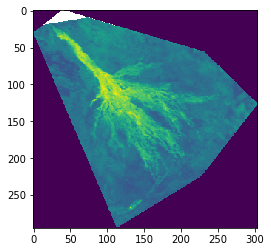

In [53]:
# Define the image
col = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(period[0],period[0+1])
img = col.mean().clip(aoi).unmask(-1)

# Get array
arr = gee_to_numpy(img,delta)

# Replace pixel with -1 values by NaN
arr[np.where(arr == -1)] = np.nan

# Plot the image
plt.imshow(arr)

In [54]:
period_all = np.array(pd.period_range('2000-02', '2017-12', freq='M').to_series().astype(str))

In [55]:
index_NDVI = []
index_CHIRPS = []
for t in range(len(period_all)-1):
    # Get image
    col_NDVI = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(period_all[t],period_all[t+1])
    col_CHIRPS = ee.ImageCollection(f'UCSB-CHG/CHIRPS/PENTAD').filterDate(period_all[t],period_all[t+1])
        
    img_NDVI = col_NDVI.mean().clip(aoi).unmask(-1)
    img_CHIRPS = col_CHIRPS.mean().clip(aoi).unmask(-1)
    # Get array
    arr_NDVI = gee_to_numpy(img_NDVI,delta)
    arr_CHIRPS = gee_to_numpy(img_CHIRPS,delta)
    # Replace pixel with -1 values by NaN
    arr_NDVI[np.where(arr_NDVI == -1)] = np.nan
    arr_CHIRPS[np.where(arr_CHIRPS == -1)] = np.nan
    
    index_NDVI.append(np.nanmean(arr_NDVI))
    index_CHIRPS.append(np.nanmean(arr_CHIRPS))

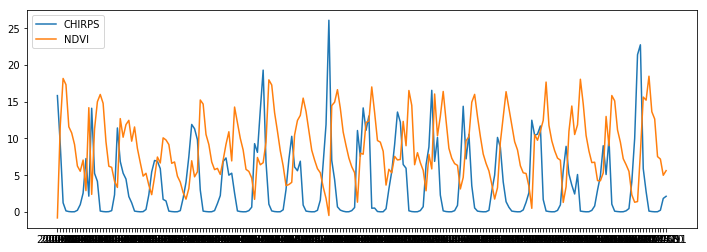

In [56]:
fig, ax = plt.subplots(figsize=[12,4])
ax.plot(period_all[:-1],np.array(index_CHIRPS), label='CHIRPS')
ax.plot(period_all[:-1],np.array(index_NDVI)*100-10, label='NDVI')
ax.legend()

**Pan**

In [57]:
pan = ee.Geometry.Polygon([[24.89501953125,-20.22612029583698],
[24.49951171875,-20.406420474920292],
[24.14794921875,-21.24842223562701],
[24.67529296875,-21.616579336740593],
[26.3507080078125,-21.27913739410871],
[26.8890380859375,-20.030128899024707],
[25.9552001953125,-19.694314241825747],
[24.89501953125,-20.22612029583698]])

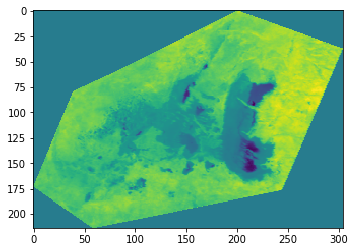

In [58]:
# Define the image
col = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(period[5],period[5+1])
img = col.mean().clip(aoi).unmask(-1)

# Get array
arr = gee_to_numpy(img,pan)

# Replace pixel with -1 values by NaN
arr[np.where(arr == -1)] = np.nan

# Plot the image
plt.imshow(arr)

In [59]:
index_NDVI = []
index_CHIRPS = []
for t in range(len(period)-1):
    # Get image
    col_NDVI = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(period[t],period[t+1])
    col_CHIRPS = ee.ImageCollection(f'UCSB-CHG/CHIRPS/PENTAD').filterDate(period[t],period[t+1])
        
    img_NDVI = col_NDVI.mean().clip(aoi).unmask(-1)
    img_CHIRPS = col_CHIRPS.mean().clip(aoi).unmask(-1)
    # Get array
    arr_NDVI = gee_to_numpy(img_NDVI,pan)
    arr_CHIRPS = gee_to_numpy(img_CHIRPS,pan)
    # Replace pixel with -1 values by NaN
    arr_NDVI[np.where(arr_NDVI == -1)] = np.nan
    arr_CHIRPS[np.where(arr_CHIRPS == -1)] = np.nan
    
    index_NDVI.append(np.nanmean(arr_NDVI))
    index_CHIRPS.append(np.nanmean(arr_CHIRPS))

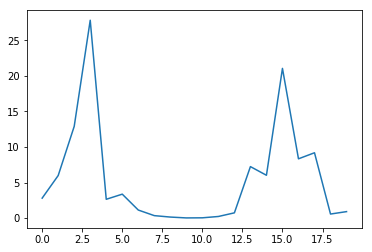

In [60]:
plt.plot(index_CHIRPS)

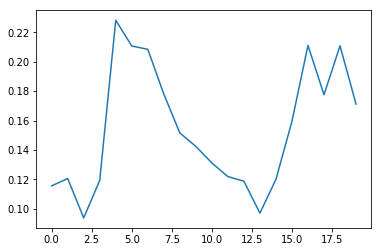

In [61]:
plt.plot(index_NDVI)

# Buffalo data

In [62]:
buffalo = pd.read_csv('./data/Cape buffalo movements in the Okavango Delta, Botswana.csv')

In [63]:
buffalo.head()

,event-id,visible,timestamp,location-long,location-lat,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name
0,4851988779,True,2007-01-10 09:00:00.000,23.307140,-19.579673,gps,Syncerus caffer,B1-Tag,B1,"Cape buffalo movements in the Okavango Delta, ..."
1,4851988778,True,2007-01-10 10:00:00.000,23.307110,-19.579647,gps,Syncerus caffer,B1-Tag,B1,"Cape buffalo movements in the Okavango Delta, ..."
2,4851988777,True,2007-01-10 11:00:00.000,23.307120,-19.579773,gps,Syncerus caffer,B1-Tag,B1,"Cape buffalo movements in the Okavango Delta, ..."
3,4851988776,True,2007-01-10 12:00:00.000,23.310133,-19.580575,gps,Syncerus caffer,B1-Tag,B1,"Cape buffalo movements in the Okavango Delta, ..."
4,4851988775,True,2007-01-10 13:00:00.000,23.293838,-19.586777,gps,Syncerus caffer,B1-Tag,B1,"Cape buffalo movements in the Okavango Delta, ..."


# Animations

### Zebra migration area 

In [64]:
# Define migration area
migration_area = gdf_time.geometry.buffer(1.2).unary_union
migration_geometry = shapely.geometry.mapping(migration_area)
migration_border = gpd.GeoDataFrame({'geometry': [migration_area]})

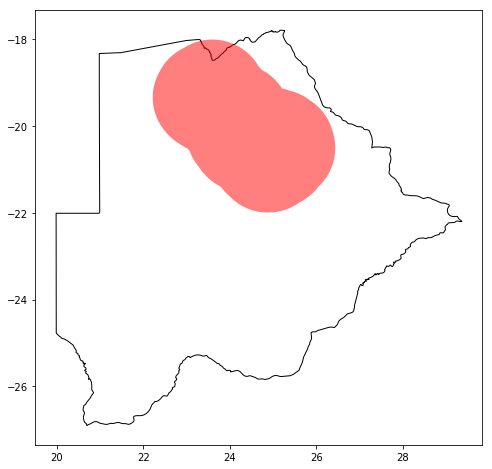

In [65]:
fig, ax = plt.subplots(figsize=[8,8])

bwa_border.geometry.plot(ax=ax, color='white', edgecolor='black')
migration_border.plot(ax=ax, color='r', alpha=0.5)

Period:  2007-10 2007-11


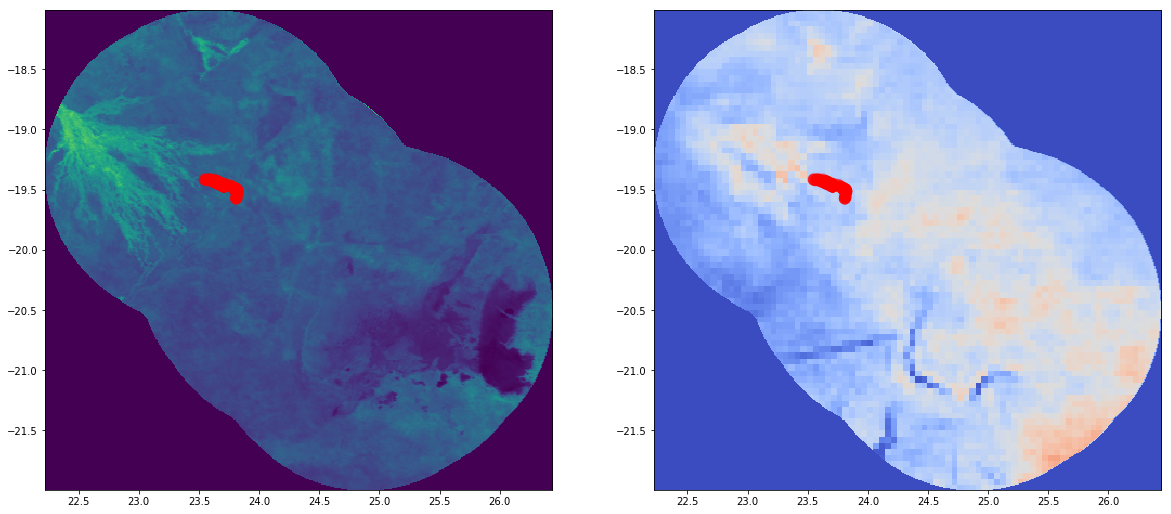

In [66]:
# Define the area
area = ee.Geometry(migration_geometry)

# Build box from migration boundary
xmin = migration_border.bounds.minx[0]
xmax = migration_border.bounds.maxx[0]
ymin = migration_border.bounds.miny[0]
ymax = migration_border.bounds.maxy[0]

for t in range(1):
#for t in range(len(period)-1):
    print('Period: ', period[t], period[t+1])
    # Zebra data
    gdf_period = gdf_time[(gdf_time['timestamp'] > period[t]) & (gdf_time['timestamp'] < period[t+1])]

    # Define the image
    col_NDVI = ee.ImageCollection(f'MODIS/MOD09GA_006_NDVI').filterDate(period[t],period[t+1])
    col_CHIRPS = ee.ImageCollection(f'UCSB-CHG/CHIRPS/PENTAD').filterDate(period[t],period[t+1])
    
    img_NDVI = col_NDVI.mean().clip(area).unmask(-1)  
    img_CHIRPS = col_CHIRPS.mean().clip(area).unmask(-1)
    
    # Get array
    arr_NDVI = gee_to_numpy(img_NDVI,area)
    arr_CHIRPS = gee_to_numpy(img_CHIRPS,area)
    
    # Replace pixel with -1 values by NaN
    arr_NDVI[np.where(arr_NDVI == -1)] = np.nan
    arr_CHIRPS[np.where(arr_NDVI == -1)] = np.nan
    
    # Plot the image
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[20,10])

    ax[0].imshow(arr_NDVI, extent=[xmin,xmax,ymin,ymax], vmin=0, vmax=0.8)
    gdf_period.geometry.buffer(0.05).plot(ax=ax[0], color='r', alpha=0.5)
    
    ax[1].imshow(arr_CHIRPS, extent=[xmin,xmax,ymin,ymax], vmax=10, vmin=0, cmap='coolwarm')
    gdf_period.geometry.buffer(0.05).plot(ax=ax[1], color='r', alpha=0.5)
    
    #fig.savefig("./images/migration_"+period[t]+".png",bbox_inches='tight')    

### Botswana 

In [67]:
# Edges of the rectangle around Botswana
xmin = 19.5
xmax = 29.8
ymin = -27.5
ymax = -17.5

In [68]:
period

array(['2007-10', '2007-11', '2007-12', '2008-01', '2008-02', '2008-03',
       '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09',
       '2008-10', '2008-11', '2008-12', '2009-01', '2009-02', '2009-03',
       '2009-04', '2009-05', '2009-06'], dtype=object)

**ALL**

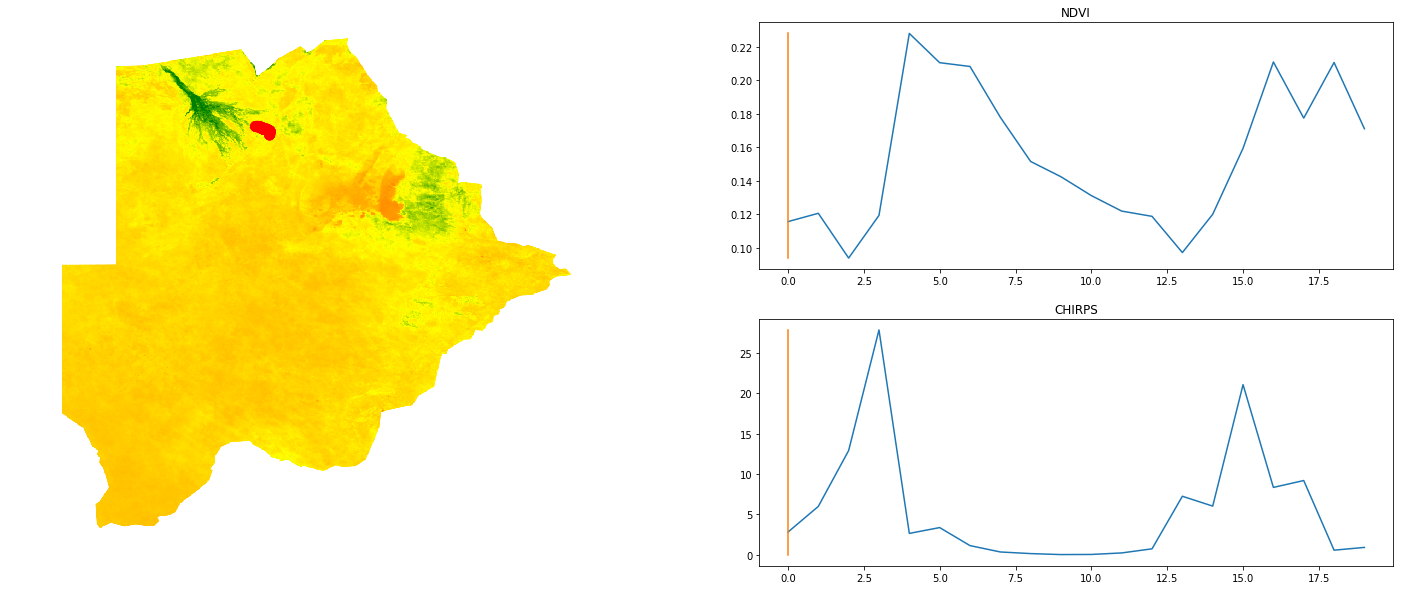

In [69]:
for t in range(1):
#for t in range(len(period)-1):
    # Zebra data
    gdf_period = gdf_time[(gdf_time['timestamp'] > period[t]) & (gdf_time['timestamp'] < period[t+1])]
    
    # Layers' path
    path = './images/NDVI/period/NDVI_'+period[t]+'.png'

    # Location
    loc = gdf_period[['lat', 'lng']]
    
    #fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,10])
    plt.figure(figsize=[25,10])
    
    gs = gridspec.GridSpec(nrows=2, ncols=2)
    ax1 = plt.subplot(gs[:, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[1, 1])
    
    # NDVI map
    ax1.imshow(plt.imread(path), extent=[xmin,xmax,ymin,ymax])
    #loc.plot(ax=ax, x='lng', y='lat', kind='scatter', color='r')
    gdf_period.geometry.buffer(0.1).plot(ax=ax1, color='r', alpha=1)
    ax1.axis('off')
    
    # NDVI evolution
    ax2.plot(index_NDVI)
    ax2.plot([t,t],[min(index_NDVI),max(index_NDVI)])
    ax2.set_title('NDVI')
    
    # CHIRPS evolution
    ax3.plot(index_CHIRPS)
    ax3.plot([t,t],[min(index_CHIRPS),max(index_CHIRPS)])
    ax3.set_title('CHIRPS')

    #plt.savefig("./images/ALL/period_evo/migration_"+str('{:02d}'.format(t))+".png");

**NDVI**

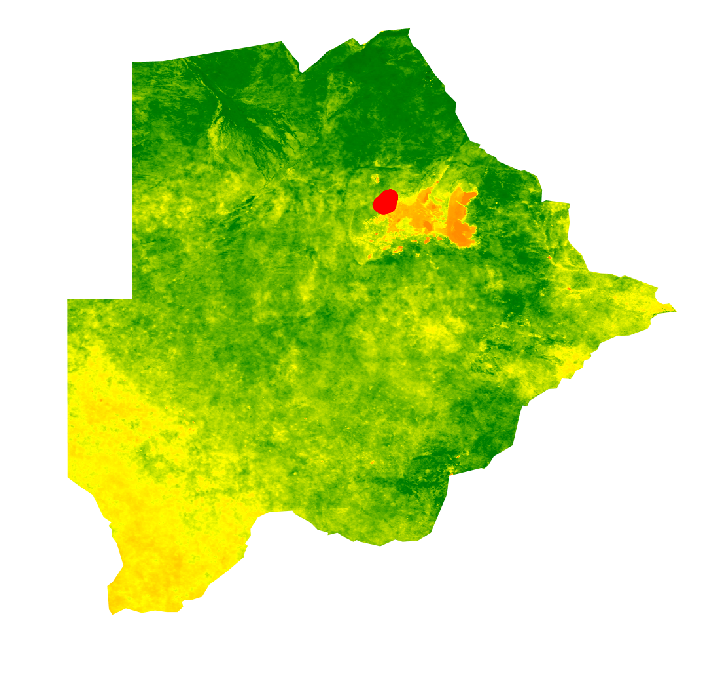

In [70]:
dt = 30
step = 5
for t in range(1):
#for t in range(len(period)-1):
    # Zebra data
    gdf_period = gdf_time[(gdf_time['timestamp'] > period2[t+(step*t)]) & (gdf_time['timestamp'] < period2[t+(step*t)+20])]
    
    # Layers' path
    path = './images/NDVI/period2_5days/NDVI_'+period2[t+(step*t)]+'.png'

    # Location
    loc = gdf_period[['lat', 'lng']]
    
    fig, ax = plt.subplots(figsize=[12,12])
    
    ax.imshow(plt.imread(path), extent=[xmin,xmax,ymin,ymax])
    #loc.plot(ax=ax, x='lng', y='lat', kind='scatter', color='r')
    gdf_period.geometry.buffer(0.1).plot(ax=ax, color='r', alpha=1)
    ax.axis('off')
    
    #fig.savefig("./images/ALL/NDVI/period2_5days/migration_"+str('{:02d}'.format(t))+".png",bbox_inches='tight');

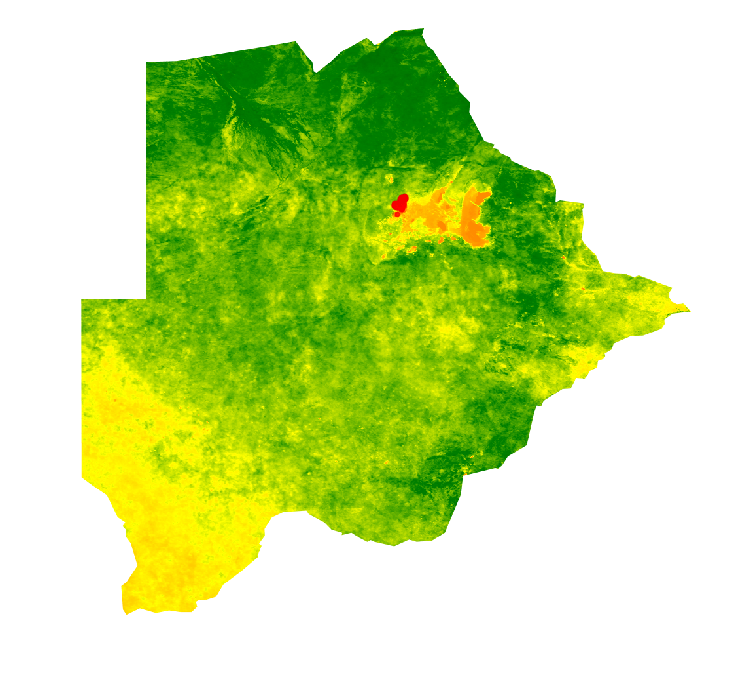

In [71]:
dt = 30
for t in range(1):
#for t in range(len(period2)-dt):
    # Zebra data
    gdf_period = gdf_time[(gdf_time['timestamp'] > period2[t]) & (gdf_time['timestamp'] < period2[t+dt])]
    
    # Layers' path
    path = './images/NDVI/NDVI_'+period2[t]+'.png'
    
    # Location
    loc = gdf_period[['lat', 'lng']]

    fig, ax = plt.subplots(figsize=[12,12])
    
    ax.imshow(plt.imread(path), extent=[xmin,xmax,ymin,ymax])
    loc.plot(ax=ax, x='lng', y='lat', kind='scatter', color='r', alpha=0.1)
    #gdf_period.geometry.buffer(0.05).plot(ax=ax, color='r', alpha=0.1)
    ax.axis('off')
    
    #fig.savefig("./images/ALL/NDVI/period2_5days/migration_"+str('{:03d}'.format(t))+".png",bbox_inches='tight');

**MODIS**

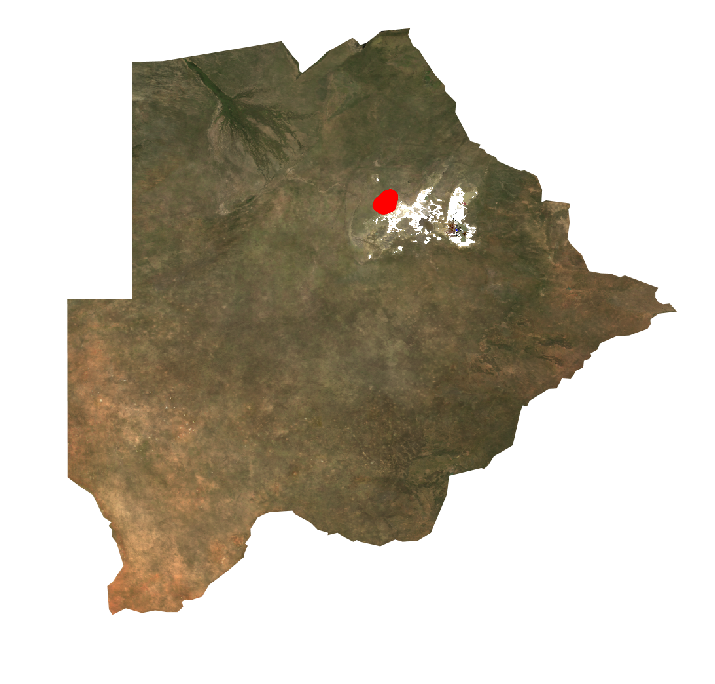

In [72]:
dt = 30
step = 5
for t in range(1):
#for t in range(len(period)-1):
    # Zebra data
    gdf_period = gdf_time[(gdf_time['timestamp'] > period2[t+(step*t)]) & (gdf_time['timestamp'] < period2[t+(step*t)+20])]
    
    # Layers' path
    path = './images/MODIS/period2_5days/MODIS_'+period2[t+(step*t)]+'.png'

    fig, ax = plt.subplots(figsize=[12,12])
    
    ax.imshow(plt.imread(path), extent=[xmin,xmax,ymin,ymax])
    gdf_period.geometry.buffer(0.1).plot(ax=ax, color='r')
    ax.axis('off')
    
    #fig.savefig("./images/ALL/MODIS/period2_5days/migration_"+str('{:02d}'.format(t))+".png",bbox_inches='tight');

**Overlap Buffalo Zebra**

In [73]:
buffalo['timestamp'].min(), buffalo['timestamp'].max()

('2007-01-09 11:00:00.000', '2010-08-01 00:00:00.000')

In [74]:
period_buffalo = np.array(pd.period_range('2007-01', '2010-08', freq='M').to_series().astype(str))

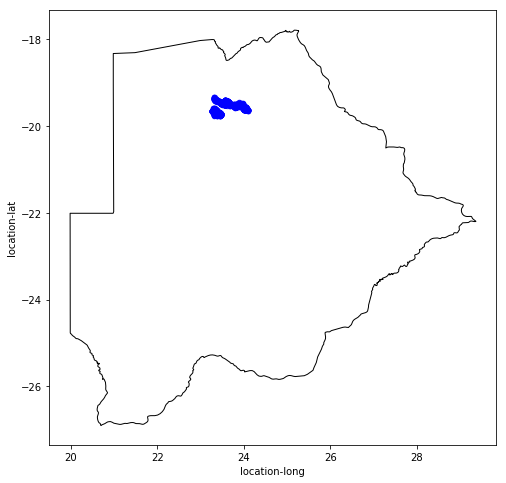

In [75]:
for t in range(1):
#for t in range(len(period_buffalo)-1):
    # Zebra data
    gdf_period = gdf_time[(gdf_time['timestamp'] > period_buffalo[t]) & (gdf_time['timestamp'] < period_buffalo[t+1])]

    # Buffalo data
    buffalo_period = buffalo[(buffalo['timestamp'] > period_buffalo[t]) & (buffalo['timestamp'] < period_buffalo[t+1])]

    fig, ax = plt.subplots(figsize=[8,8])

    bwa_border.geometry.plot(ax=ax, color='white', edgecolor='black')
    if len(gdf_period) > 0:
        gdf_period.geometry.buffer(0.1).plot(ax=ax,color='r',alpha=0.5)
    if len(buffalo_period) > 0:
        buffalo_period.plot(ax=ax, x='location-long', y='location-lat', kind='scatter',color='b',alpha=0.5)
        
    #fig.savefig("./images/BuffaloVsZebra/migration_"+str('{:02d}'.format(t))+".png",bbox_inches='tight');